In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import folium



In [25]:
file_path = '../data/202311-divvy-tripdata/202311-divvy-tripdata.csv'  
data = pd.read_csv(file_path)

data['started_at'] = pd.to_datetime(data['started_at'])
data['ended_at'] = pd.to_datetime(data['ended_at'])

data['hour'] = data['started_at'].dt.hour
data['is_peak_time'] = data['hour'].apply(lambda x: 1 if (7 <= x <= 9 or 17 <= x <= 19) else 0)





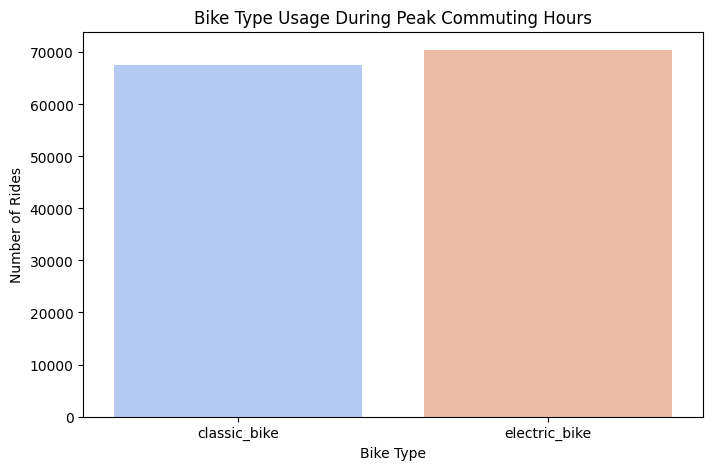

Chi-Square Test for Peak Hours: p-value = 1.0000


In [26]:
# Research Question 1: Are electric bikes used more frequently during peak commuting hours?
peak_time_data = data[data['is_peak_time'] == 1]
peak_usage = peak_time_data.groupby('rideable_type').size()
total_peak_rides = peak_usage.sum()

plt.figure(figsize=(8, 5))
sns.barplot(x=peak_usage.index, y=peak_usage.values, palette='coolwarm')
plt.title("Bike Type Usage During Peak Commuting Hours")
plt.xlabel("Bike Type")
plt.ylabel("Number of Rides")
plt.show()

ct_peak = pd.crosstab(peak_time_data['rideable_type'], peak_time_data['is_peak_time'])
chi2_peak, p_peak, dof_peak, ex_peak = chi2_contingency(ct_peak)
print(f"Chi-Square Test for Peak Hours: p-value = {p_peak:.4f}")


In [27]:
import numpy as np

data['trip_duration'] = (data['ended_at'] - data['started_at']).dt.total_seconds() / 60

def haversine(lat1, lon1, lat2, lon2):
    R = 3958.8  # Earth radius in miles
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

data['trip_distance'] = haversine(
    data['start_lat'], data['start_lng'], data['end_lat'], data['end_lng']
)

data = data[data['trip_duration'] > 0.1] 

data['trip_speed'] = data['trip_distance'] / (data['trip_duration'] / 60)

stats = data.groupby('rideable_type').agg({
    'trip_distance': 'mean',
    'trip_duration': 'mean',
    'trip_speed': 'mean'
}).reset_index()

electric_stats = stats[stats['rideable_type'] == 'electric_bike']
classic_stats = stats[stats['rideable_type'] == 'classic_bike']

time_saved_per_mile = (
    (classic_stats['trip_duration'] / classic_stats['trip_distance']).values[0] - 
    (electric_stats['trip_duration'] / electric_stats['trip_distance']).values[0]
)

print(f"Average trip stats by bike type (in miles and minutes):\n{stats}")
print(f"\nTime saved per mile on electric bikes vs classic bikes: {time_saved_per_mile:.2f} minutes/mile")

time_saved_per_trip = classic_stats['trip_duration'].values[0] - electric_stats['trip_duration'].values[0]
print(f"\nTime saved per trip on electric bikes vs classic bikes: {time_saved_per_trip:.2f} minutes")


Average trip stats by bike type (in miles and minutes):
   rideable_type  trip_distance  trip_duration  trip_speed
0   classic_bike       1.099297      17.540552    5.994117
1  electric_bike       1.293432      10.408133    8.284791

Time saved per mile on electric bikes vs classic bikes: 7.91 minutes/mile

Time saved per trip on electric bikes vs classic bikes: 7.13 minutes


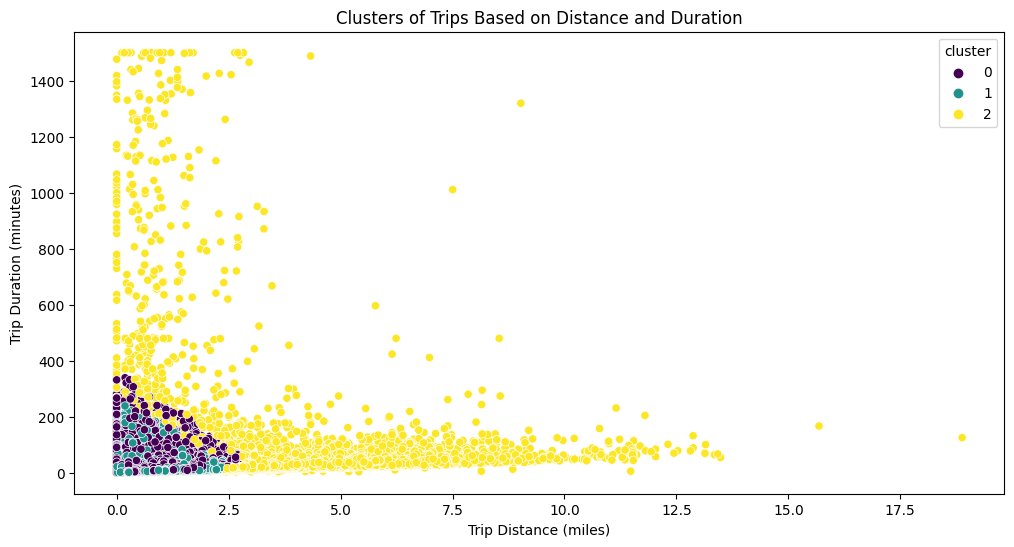

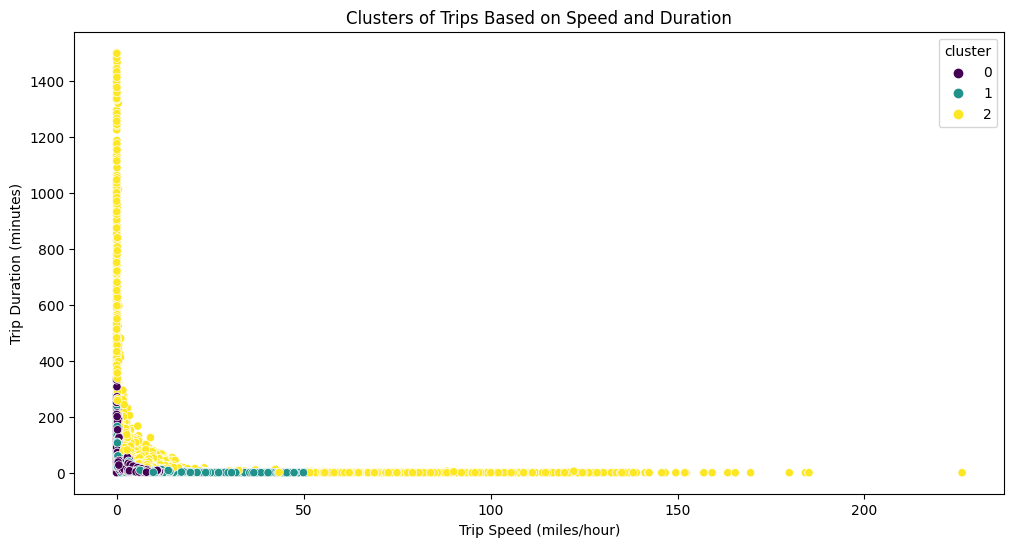

Cluster Summary:
          trip_distance  trip_duration  trip_speed  rideable_type
cluster                                                         
0             0.871753      11.512310    5.862822       1.000000
1             0.945299       8.383526    7.809400       0.000000
2             3.575148      32.744431    9.947640       0.354199


In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

data['trip_duration'] = (data['ended_at'] - data['started_at']).dt.total_seconds() / 60
data['trip_speed'] = data['trip_distance'] / (data['trip_duration'] / 60)

features = data[['trip_distance', 'trip_duration', 'trip_speed', 'rideable_type']]
features = features.dropna()

features['rideable_type'] = features['rideable_type'].map({'electric_bike': 0, 'classic_bike': 1})

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)  
features['cluster'] = kmeans.fit_predict(features_scaled)

cluster_summary = features.groupby('cluster').mean()

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=features['trip_distance'], 
    y=features['trip_duration'], 
    hue=features['cluster'], 
    palette='viridis'
)
plt.title("Clusters of Trips Based on Distance and Duration")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Trip Duration (minutes)")
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=features['trip_speed'], 
    y=features['trip_duration'], 
    hue=features['cluster'], 
    palette='viridis'
)
plt.title("Clusters of Trips Based on Speed and Duration")
plt.xlabel("Trip Speed (miles/hour)")
plt.ylabel("Trip Duration (minutes)")
plt.show()

print("Cluster Summary:\n", cluster_summary)


## Conclusions
Electric Bikes Are Popular for Commuting:

They dominate Cluster 1, where speed and efficiency are critical. This makes them ideal for peak hours and urban commuters.
Classic Bikes Are Popular for Leisure:

They dominate Cluster 0, where affordability and a relaxed pace are more important, catering to casual users and tourists.
Both Bike Types Are Used for Long-Distance Trips:

In Cluster 2, riders choose between electric bikes (for convenience) and classic bikes (for cost savings). The preference depends on user type and urgency.


## Recommendations
Optimize Fleet Distribution:

Increase electric bike availability during peak hours and at high-traffic commuter stations (aligned with Cluster 1 behavior).
Focus classic bikes at recreational hotspots and areas popular with tourists (aligned with Cluster 0 behavior).

Raw Counts and Percentages of Bike Types by Rider Type:
                ride_count                 percentage              
rideable_type classic_bike electric_bike classic_bike electric_bike
member_casual                                                      
casual             42450.0       55641.0    43.276142     56.723858
member            133188.0      130080.0    50.590273     49.409727

Correlation Matrix:
               trip_distance  trip_duration  trip_speed  rideable_type  \
trip_distance       1.000000       0.202877    0.277939      -0.089939   
trip_duration       0.202877       1.000000   -0.136724       0.068958   
trip_speed          0.277939      -0.136724    1.000000      -0.274755   
rideable_type      -0.089939       0.068958   -0.274755       1.000000   
member_casual      -0.020278       0.076223   -0.105082      -0.066150   

               member_casual  
trip_distance      -0.020278  
trip_duration       0.076223  
trip_speed         -0.105082  
rideable_type 

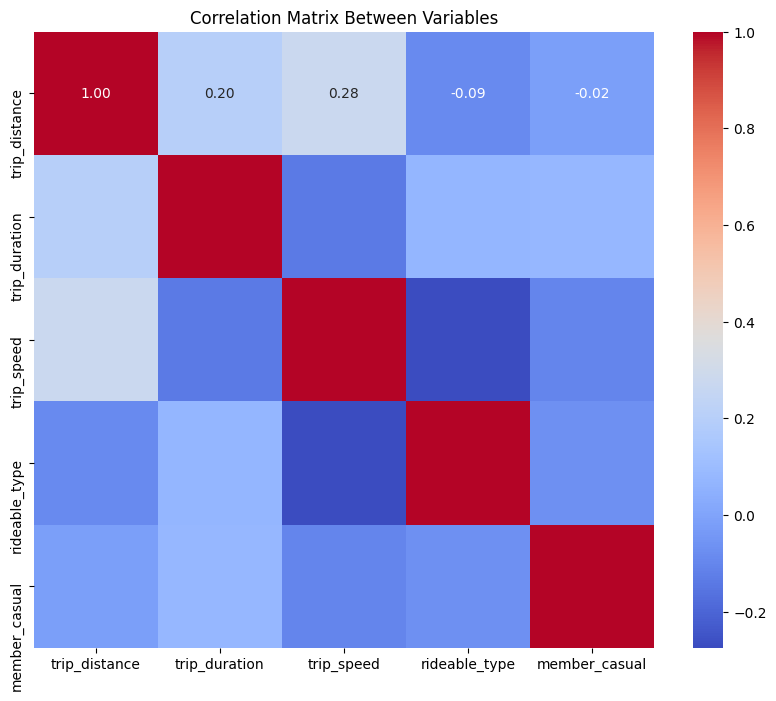

NameError: name 's' is not defined

In [29]:
# Question 2: Do members use electric bikes more frequently than casual riders, regardless of the time of day?

bike_usage_counts = data.groupby(['member_casual', 'rideable_type']).size().reset_index(name='ride_count')

total_rides_by_rider = bike_usage_counts.groupby('member_casual')['ride_count'].transform('sum')
bike_usage_counts['percentage'] = (bike_usage_counts['ride_count'] / total_rides_by_rider) * 100

bike_usage_pivot = bike_usage_counts.pivot(index='member_casual', columns='rideable_type', values=['ride_count', 'percentage'])

print("Raw Counts and Percentages of Bike Types by Rider Type:")
print(bike_usage_pivot)

correlation_data = data[['trip_distance', 'trip_duration', 'trip_speed', 'rideable_type', 'member_casual']].dropna()

correlation_data['rideable_type'] = correlation_data['rideable_type'].map({'electric_bike': 0, 'classic_bike': 1})
correlation_data['member_casual'] = correlation_data['member_casual'].map({'member': 0, 'casual': 1})

correlation_matrix = correlation_data.corr()

print("\nCorrelation Matrix:")
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix Between Variables")
plt.show()

s
sns.boxplot(data=correlation_data, x='member_casual', y='trip_duration', hue='rideable_type')
plt.title("Trip Duration by Member Type and Bike Type")
plt.xlabel("Rider Type (0=Member, 1=Casual)")
plt.ylabel("Trip Duration (minutes)")
plt.show()

sns.boxplot(data=correlation_data, x='member_casual', y='trip_speed', hue='rideable_type')
plt.title("Trip Speed by Member Type and Bike Type")
plt.xlabel("Rider Type (0=Member, 1=Casual)")
plt.ylabel("Trip Speed (miles/hour)")
plt.show()

sns.boxplot(data=correlation_data, x='member_casual', y='trip_distance', hue='rideable_type')
plt.title("Trip Distance by Member Type and Bike Type")
plt.xlabel("Rider Type (0=Member, 1=Casual)")
plt.ylabel("Trip Distance (miles)")
plt.show()


2. Correlation Matrix
The heatmap highlights the relationships between variables:

Negative Correlation Between rideable_type and trip_speed:
Suggests that electric bikes (coded as 0) have higher speeds compared to classic bikes (coded as 1), confirming their efficiency.
Weak Correlation Between rideable_type and trip_distance:
Indicates that both bike types are used across similar distances, but electric bikes might dominate longer trips slightly due to ease of use.
Very Weak Correlation Between member_casual and rideable_type:
Suggests that while members use electric bikes more often than casual riders, the distinction is not strongly polarized.



Key Insights
Members Use Electric Bikes More Frequently:

The higher percentage of electric bike usage among members indicates a preference for faster and more efficient transportation, especially for commuting.
Casual Riders Favor Classic Bikes:

Casual riders gravitate towards classic bikes due to lower costs, longer trip durations, and leisurely use cases.
Electric Bikes Provide Speed and Convenience:

Electric bikes are significantly faster and save time, making them ideal for members with time-sensitive needs.
Casual riders may not fully capitalize on this benefit, as their primary focus appears to be leisure.
Trip Attributes Influence Bike Type:

Shorter durations and higher speeds strongly correlate with electric bikes, particularly for members.
Longer durations and moderate speeds align more with casual riders and classic bikes.



Recommendations
Electric Bike Availability:
Ensure a higher number of electric bikes at commuter-heavy stations to cater to members' preferences.
Cost-Effective Plans for Casual Riders:
Introduce affordable electric bike packages to encourage casual riders to try them for longer or more efficient trips.
Targeted Marketing:
Emphasize speed and convenience in electric bike promotions aimed at members.
Highlight affordability and ease of use in campaigns for classic bikes targeted at casual riders.

In [ ]:
electric_trips = data[
    (data['rideable_type'] == 'electric_bike') & (data['is_peak_time'] == 1) & (data['member_casual'] == "member") &
    data[['start_lat', 'start_lng', 'end_lat', 'end_lng']].notnull().all(axis=1)
]
classic_trips = data[
    (data['rideable_type'] == 'classic_bike') & (data['is_peak_time'] == 1) & (data['member_casual'] == "member") &
    data[['start_lat', 'start_lng', 'end_lat', 'end_lng']].notnull().all(axis=1)
]



In [ ]:


chicago_map = folium.Map(location=[41.881, -87.629], zoom_start=12)

for _, row in electric_trips.iterrows():
    folium.PolyLine(
        [(row['start_lat'], row['start_lng']), (row['end_lat'], row['end_lng'])],
        color='blue',
        weight=2,
        opacity=0.7,
        tooltip=f"Electric Bike Trip: Start at ({row['start_lat']}, {row['start_lng']}), "
                f"End at ({row['end_lat']}, {row['end_lng']})"
    ).add_to(chicago_map)

for _, row in classic_trips.iterrows():
    folium.PolyLine(
        [(row['start_lat'], row['start_lng']), (row['end_lat'], row['end_lng'])],
        color='green',
        weight=2,
        opacity=0.7,
        tooltip=f"Classic Bike Trip: Start at ({row['start_lat']}, {row['start_lng']}), "
                f"End at ({row['end_lat']}, {row['end_lng']})"
    ).add_to(chicago_map)


In [ ]:
# map_file_path = "Chicago_Bike_Trips_Map.html" DONT RUN, THIS TAKES TOO LONG TO GENERATE
# chicago_map.save(map_file_path)



C:\Users\rohan\AppData\Local\Temp\ipykernel_12012\2356644401.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_based_usage = data.groupby(['member_casual', 'rideable_type', 'time_of_day']).size().unstack(level=-1, fill_value=0)


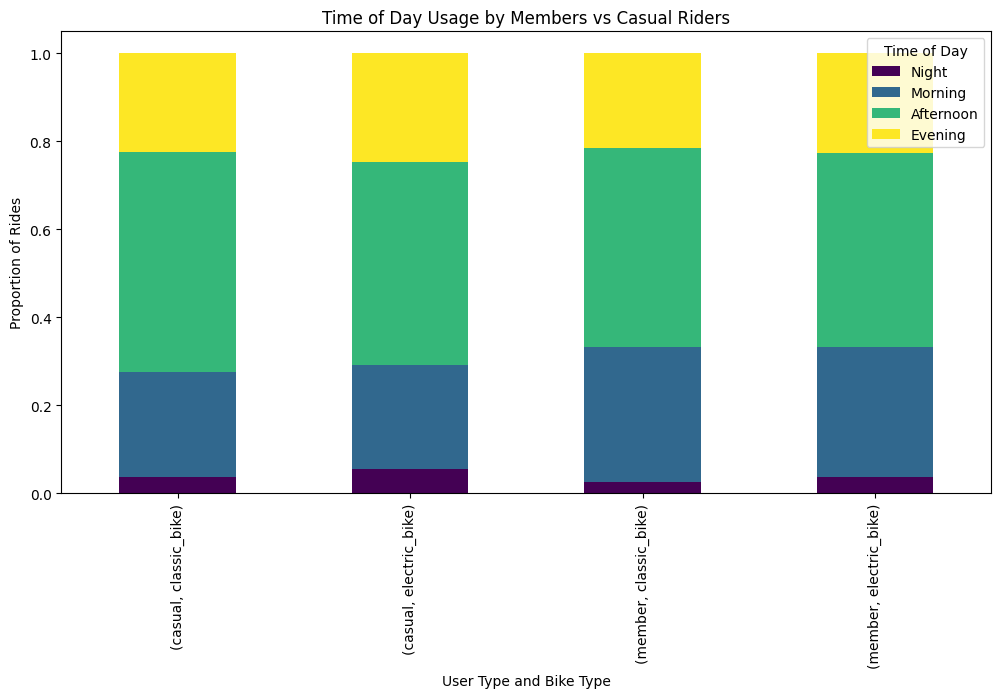

In [ ]:
data['hour'] = pd.to_datetime(data['started_at']).dt.hour
data['time_of_day'] = pd.cut(
    data['hour'],
    bins=[0, 6, 12, 18, 24],
    labels=["Night", "Morning", "Afternoon", "Evening"],
    right=False
)

time_based_usage = data.groupby(['member_casual', 'rideable_type', 'time_of_day']).size().unstack(level=-1, fill_value=0)

time_based_usage = time_based_usage.div(time_based_usage.sum(axis=1), axis=0)

time_based_usage.plot(kind='bar', figsize=(12, 6), stacked=True, colormap='viridis')
plt.title("Time of Day Usage by Members vs Casual Riders")
plt.xlabel("User Type and Bike Type")
plt.ylabel("Proportion of Rides")
plt.legend(title="Time of Day")
plt.show()


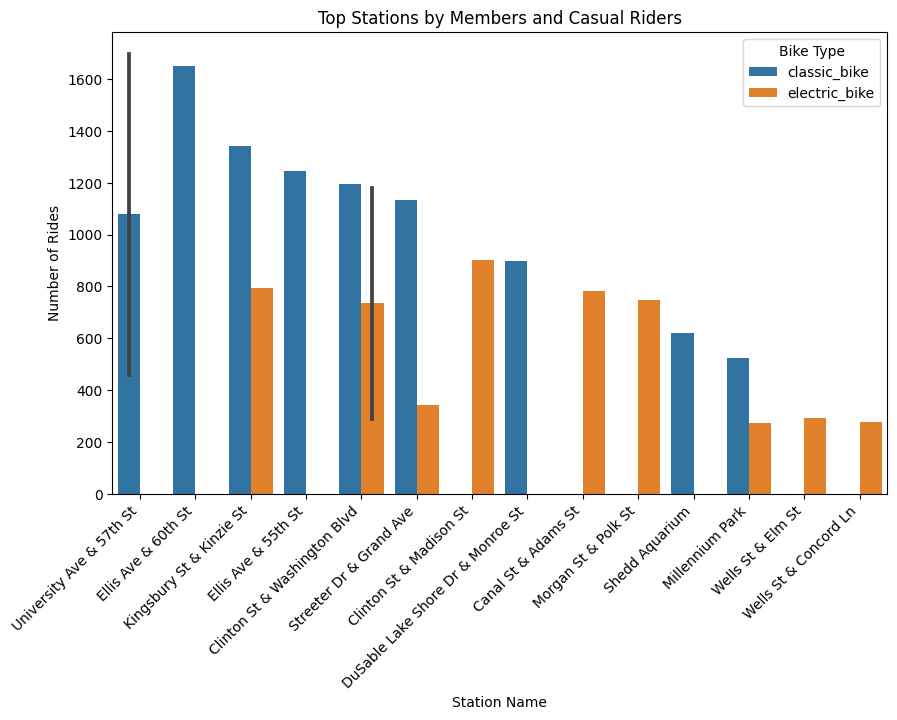

In [ ]:
top_stations = data.groupby(['start_station_name', 'member_casual', 'rideable_type']).size().reset_index(name='ride_count')
top_stations = top_stations.sort_values('ride_count', ascending=False).groupby(['member_casual', 'rideable_type']).head(5)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_stations, x='start_station_name', y='ride_count', hue='rideable_type')
plt.title("Top Stations by Members and Casual Riders")
plt.xlabel("Station Name")
plt.ylabel("Number of Rides")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Bike Type")
plt.show()


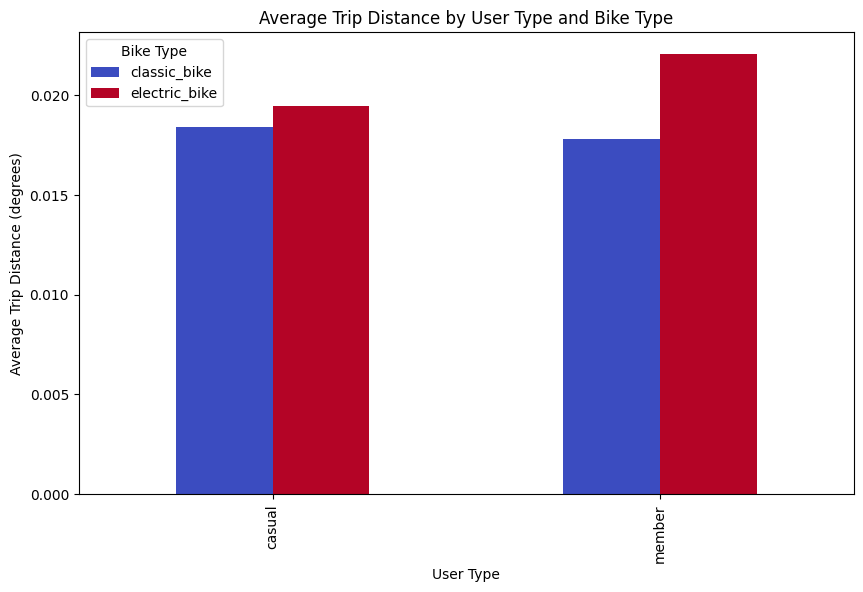

In [ ]:
import numpy as np

data['trip_distance'] = np.sqrt(
    (data['end_lat'] - data['start_lat'])**2 + (data['end_lng'] - data['start_lng'])**2
)

distance_analysis = data.groupby(['member_casual', 'rideable_type'])['trip_distance'].mean().unstack()

distance_analysis.plot(kind='bar', figsize=(10, 6), colormap='coolwarm')
plt.title("Average Trip Distance by User Type and Bike Type")
plt.xlabel("User Type")
plt.ylabel("Average Trip Distance (degrees)")
plt.legend(title="Bike Type")
plt.show()


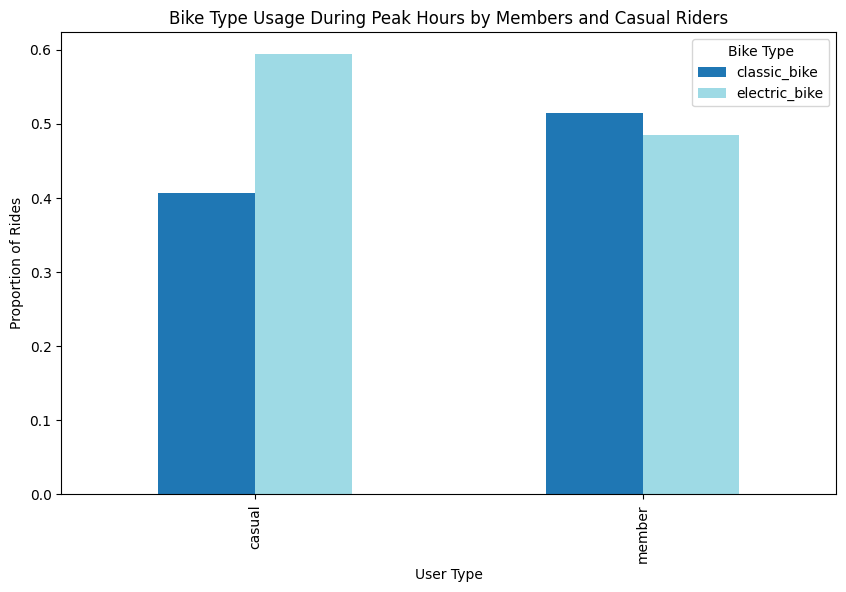

In [ ]:
data['is_peak'] = data['hour'].apply(lambda x: 1 if (7 <= x <= 9 or 17 <= x <= 19) else 0)

peak_usage = data.groupby(['is_peak', 'member_casual', 'rideable_type']).size().unstack(fill_value=0)

peak_usage_normalized = peak_usage.div(peak_usage.sum(axis=1), axis=0)

peak_usage_normalized.loc[1].plot(kind='bar', figsize=(10, 6), colormap='tab20')
plt.title("Bike Type Usage During Peak Hours by Members and Casual Riders")
plt.xlabel("User Type")
plt.ylabel("Proportion of Rides")
plt.legend(title="Bike Type")
plt.show()


In [ ]:
from scipy.stats import ttest_ind

member_electric_distances = data[(data['member_casual'] == 'member') & (data['rideable_type'] == 'electric_bike')]['trip_distance']
member_classic_distances = data[(data['member_casual'] == 'member') & (data['rideable_type'] == 'classic_bike')]['trip_distance']

t_stat, p_val = ttest_ind(member_electric_distances.dropna(), member_classic_distances.dropna())
print(f"T-Test for Members: t-stat = {t_stat:.4f}, p-value = {p_val:.4f}")


T-Test for Members: t-stat = 63.5332, p-value = 0.0000


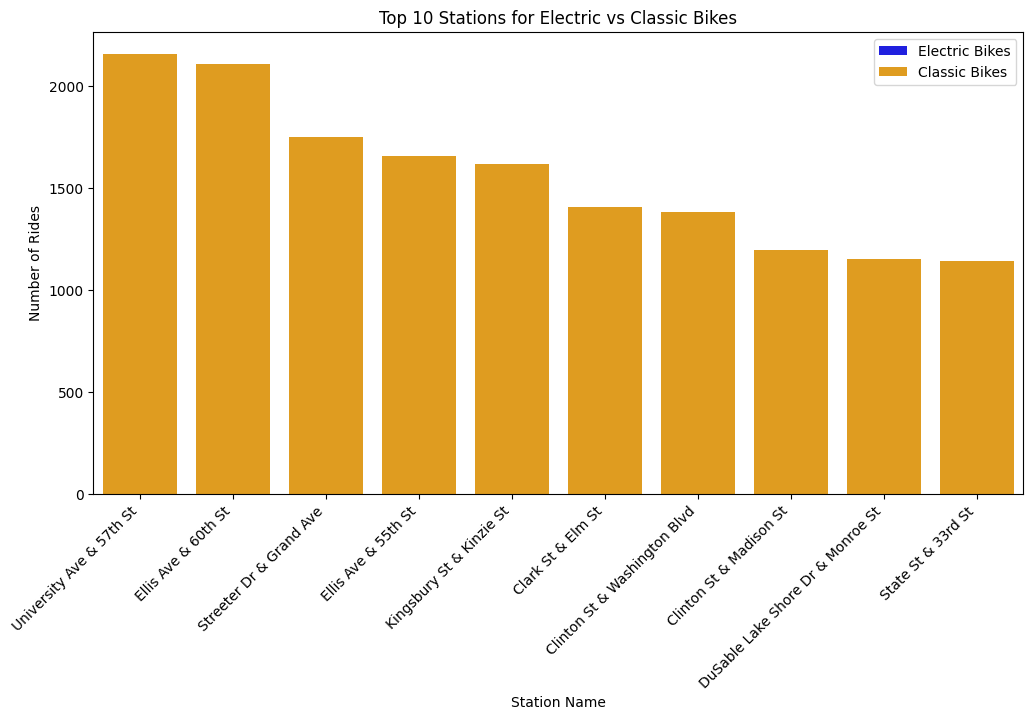

In [ ]:
station_usage = data.groupby(['start_station_name', 'rideable_type']).size().reset_index(name='ride_count')

top_stations = station_usage.groupby(['start_station_name', 'rideable_type'])['ride_count'].sum().reset_index()
top_electric_stations = top_stations[top_stations['rideable_type'] == 'electric_bike'].nlargest(10, 'ride_count')
top_classic_stations = top_stations[top_stations['rideable_type'] == 'classic_bike'].nlargest(10, 'ride_count')

plt.figure(figsize=(12, 6))
sns.barplot(data=top_electric_stations, x='start_station_name', y='ride_count', color='blue', label='Electric Bikes')
plt.xticks(rotation=45, ha="right")
sns.barplot(data=top_classic_stations, x='start_station_name', y='ride_count', color='orange', label='Classic Bikes')
plt.title("Top 10 Stations for Electric vs Classic Bikes")
plt.xlabel("Station Name")
plt.ylabel("Number of Rides")
plt.legend()
plt.show()